<a href="https://colab.research.google.com/github/smartgeometry-ucl/COMP0169-2021-CourseWorks/blob/master/CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 1: Learning Learning, From Scratch
_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Luca Morreale, Pradyumna Reddy, Sanjeev Muralikrishnan & Animesh Karnewar__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission:

Coursework submissions must comprise of this **single** jupyter notebook, containing your code and written comments. Cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any way. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#begin_solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated.

Please, do not change `#begin_test ... #end_test` blocks.

Each exercise must be implemented from scratch. Unless differently specified, only numpy and matplotlib are allowed. The libraries are imported in [the package cell](#packages) and cannot be modified.

Note: The `optimize` module from `scipy` can only be used for the question where it is specified, and not anywhere else.



**Questions:**

[Question 1](#question1): Linear Fitting (10 points)

[Question 2](#question2): Free form optimization (18 points)

[Question 3](#question3): Clustering (14 points)

[Question 4](#question4): Linear Classification (18 points)

[Question 5](#question5): Non-linear Classification (20 points)

[Question 6](#question6): Neural Networks (20 points)

## Datasets

We will be using two datasets for the whole coursework: _IRIS_ and _MNIST_. Both datasets will be downloaded directly in the notebook using the `skdataset` library. Keep in mind that you will need to be connected to Internet to be able to download the datasets. If you want to work offline, you are free to save your dataset to npy file locally and load them while offline although this is not officially supported.

**_IRIS_**: The _IRIS_ dataset contains the following features in order: _sepal length_, _sepal width_, _petal length_, _petal width_. Classes names are: __Iris Setosa__ for label **0**, __Iris Versicolour__ for label **1**, and __Iris Virginica__ for label **2**.

**_MNIST_**: _MNIST_ is a dataset composed of images of handwritten digits. The features of each image are the pixels themselves.

The script will generate two subsets for each of the two datasets, a training subset (**X\_dataset** and **Y\_dataset** with **dataset** the name of the dataset) and a test subset (**X\_dataset\_test** and **Y\_dataset\_test**).

We will test correctness of your code on _Hidden_ set.

**Warning:** as _Hidden_ may have different dimensions from _IRIS_ and _MNIST_, hard-coded solutions may not work, thus resulting in lower grades. You need to make sure that your code would work if applied on a different number of samples and a different number of features/pixels.

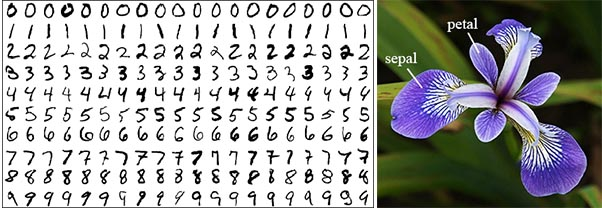

## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [1]:
# Importing packages
import numpy as np
import random

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Setting the seed
RAND_ST = 42
random.seed(RAND_ST)
#begin_test

#end_test


## Data Loading

The following cells are used to load both datasets, _Iris_ and _MNIST_.

In [3]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [4]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

## Functions for visualization

In [5]:
def plot_dataset(X, Y, dims=[0,1]):
    # Keep only two dimensions
    X_reduced = X[:, dims]
    # Plot the data points
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k')
    plt.xlabel('Feat 1')
    plt.ylabel('Feat 2')
    plt.show()

In [6]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()

In [7]:
def plot_eigenvecs(stacked_images, n_rows, n_columns):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]))
        plt.axis('off')
    plt.show()

def plot_grey_image(stacked_images, n_rows, n_columns, titles):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if len(titles) == n_rows*n_columns:
          plt.title(titles[i])
    plt.show()

In [8]:
def plot_loss_curve(logs):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(logs)
    plt.show()

In [9]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

## Data Loading

In the following cells, the dataset is created with proper splits between training and test set.

_IRIS_ dataset

In [10]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

_MNIST_ dataset

In [11]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

## 1. Linear Fitting (10 points)
<a name='question1'></a>

[a)](#question1a) Implement the normal equation solver function **nsolve**, which takes as input the matrix **X** and the target vector **y** and returns the optimized weights **w**. Test your code with your own mockup data. (**5 points**)

[b)](#question1b) Implement **line_fit(X,y)** which should fit a linear function to the input data. Test your implementation on the following task: predict with linear fitting the _petal length (cm)_ of the Iris dataset using the three remaining variables as inputs (_sepal length (cm)_, _sepal width (cm)_ and _petal width (cm)_). Report the L2 loss on the validation set and plot a graph showing the correlation between y and your prediction on the test set. (**2 points**)

[c)](#question1c) Implement **poly_fit(X,y)** which should fit a 2nd degree polynomial to the input data. Test your implementation on the following task: predict with the polynomial the petal width (cm) of the _IRIS_ dataset using the three remaining variables as inputs (sepal length (cm), sepal width (cm), petal length (cm)). The 2nd degree polynomial should consider all possible pairwise terms, i.e. $w_1x^2 + w_2xy+ w_3y^2 + w_4x+ w_5y+ w_6$ in the case of two input variables $x$ and $y$. Report the L2 loss on the validation set and plot a graph showing the correlation between $y$ and your prediction on the test set. (**3 points**)

**Question 1.a**
<a name='question1a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [12]:
def nsolve(X,y):
    """
    Write your implementation of nsolve here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights 
    """

    #begin_solution
    Xi = np.linalg.inv(X)
    w = np.dot(Xi, y)
    #end_solution


    return w

Testing your code on mockup data.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [13]:
"""
After implementing nsolve, test it below on some mock data using np.random
"""

#begin_solution
#X = np.array([[2,3],[1,2],[2,3],[1,2]])
#print(X)
#print(X.T)
#y = np.array([1,1])
#print(np.dot(X.T, X))
#XTX = np.dot(X.T, X)
#print(np.identity(XTX.shape[0]))
#print(X_iris)
#print(nsolve(X, y))
#end_solution


'\nAfter implementing nsolve, test it below on some mock data using np.random\n'

**Question 1.b**
<a name='question1b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [14]:
def line_fit(X,y):
    """
    Write your implementation of line_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 Prediction error using learned w
    """

    #begin_solution
    # print(X.shape, y.shape)
    XTX = np.dot(X.T, X)
    # print(XTX.shape)
    w = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    # print(w)
    # print(np.dot(w.T, X.T))
    l2_error = np.average(np.power(np.dot(w.T, X.T) - y, 2))
    #end_solution


    return w, l2_error

Testing your code on _IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [15]:
"""
After implementing line_fit, test it below on IRIS Train set.
Print the L2 error on the Training set.
"""

#begin_solution
w, l2_error = line_fit(X_iris[:,1:], X_iris[:,0])
print(w, l2_error)
#end_solution


[ 1.11202274  0.93677748 -0.93713269] 0.12486121141290822


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [16]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#begin_solution
l2_error_test = np.average(np.power(np.dot(w.T, X_iris_test[:,1:].T) - X_iris_test[:,0], 2))
print(l2_error_test)
#end_solution


0.2094209337551468


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

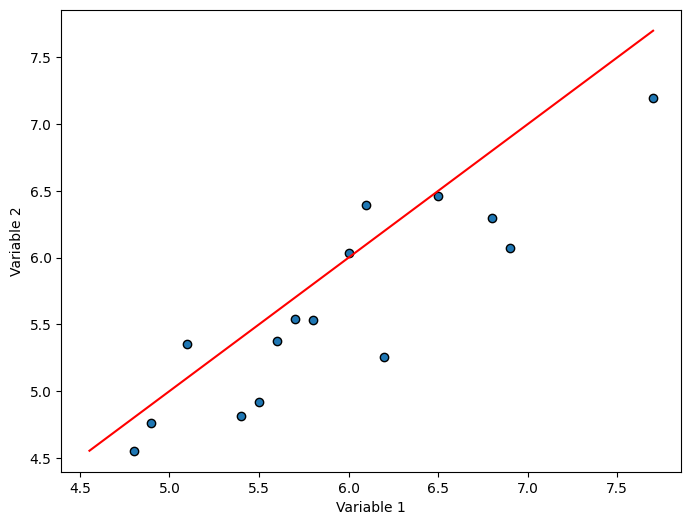

In [17]:
"""
Below, plot and display the correlation between true y and predicted values.
"""
#begin_solution
# plot_dataset(X_iris, Y_iris)
# plot_dataset(X_iris_test, Y_iris_test)
plot_correlation(X_iris_test[:,0], np.dot(w.T, X_iris_test[:,1:].T))
# plot_dataset(X_iris_test, np.dot(w.T, X_iris_test.T))
#end_solution


In [18]:
#begin_test
#end_test


**Question 1.c**
<a name='question1c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [19]:
def poly_fit(X,y):
    """
    Write your implementation of poly_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 prediction error using learned w
    """

    #begin_solution

    def genx(x):
        gx = np.array([])
        for i in range(x.shape[0]):
            gx = np.append(gx, x[i] * x[i:])
        for i in range(x.shape[0]):
            gx = np.append(gx, x[i])
        gx = np.append(gx, 1)
        return gx
    
    GX = np.zeros(shape=(X.shape[0], (X.shape[1] + 1) * X.shape[1] // 2 + X.shape[1] + 1))
    idx = 0
    for x in X:
        GX[idx] = genx(x)
        idx += 1
    
    XTX = np.dot(GX.T, GX)
    ##lam = 5
    #w = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    w = np.dot(np.linalg.inv(XTX), np.dot(GX.T, y))
    l2_error = np.average(np.power(np.dot(w.T, GX.T) - y, 2))
    #end_solution


    return w, l2_error

Testing your code on _IRIS_.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [20]:
"""
After implementing poly_fit, test it below on IRIS Training set.
Print L2 error with respect to training set.
"""

#begin_solution
#print(X_iris.shape, Y_iris.shape)
#print(X_iris, Y_iris)
w, l2_error = poly_fit(X_iris[:,1:], X_iris[:,0])
print(w, l2_error)
#end_solution


[ 0.07033644 -0.12806211  0.25885618 -0.01902332  0.35086472 -0.55316694
  0.29963229  0.76948205 -1.15940481  2.65080022] 0.08485366366275852


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [21]:
"""
After implementing poly_fit, test it below on IRIS Test set.
Print L2 error with respect to test set.
"""

#begin_solution
def genx(x):
    gx = np.array([])
    for i in range(x.shape[0]):
        gx = np.append(gx, x[i] * x[i:])
    for i in range(x.shape[0]):
        gx = np.append(gx, x[i])
    gx = np.append(gx, 1)
    return gx
X = X_iris_test[:,1:]
GX = np.zeros(shape=(X.shape[0], (X.shape[1] + 1) * X.shape[1] // 2 + X.shape[1] + 1))
idx = 0
for x in X:
    GX[idx] = genx(x)
    idx += 1
l2_error = np.average(np.power(np.dot(w.T, GX.T) - X_iris_test[:,0], 2))
print(l2_error)
#end_solution


0.14085746716657488


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

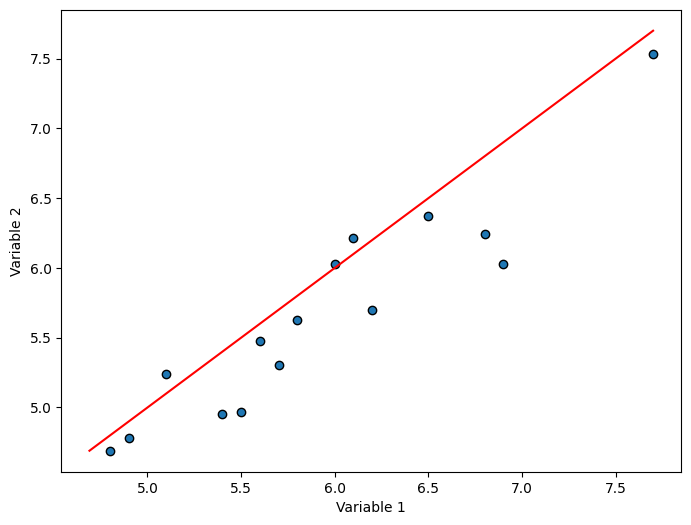

In [22]:
"""
Below, plot and display the correlation between true y and predicted values
"""

#begin_solution
plot_correlation(X_iris_test[:,0], np.dot(w.T, GX.T))
#end_solution


In [23]:
#begin_test

#end_test


## 2. Free form optimization (18 points)
<a name='question2'></a>

[a)](#question2a) Implement Gradient Descent (GD) (**3 points**), Gradient Descent with Nesterov Momentum (GDN)  (**4 points**) and a second order optimization method (**4 points**)

[b)](#question2b) Write the gradient and hessian of "paraboloid" and run the optimization methods on it (**7 points** on hidden test)

**Question 2.a**
<a name='question2a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [24]:
def gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change=1.0e-6):
    """
    Write your own implementation of gradient descent here.
    
    Arguments:
    
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     derivative of the function to minimize - R^N -> R^N
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution
    minimizer_change = 2 * eps_change
    while current_it < max_iterations and minimizer_change > eps_change:
        old_minimizer = minimizer.copy()
        minimizer -= step_size * d_objective(minimizer)
        minimizer_change = np.sqrt(np.sum((old_minimizer - minimizer) * (old_minimizer - minimizer)))
        current_it += 1
    #end_solution

        
    return minimizer, current_it + 1
    

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [25]:
def gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change):
    """
    Write your own implementation of gradient descent with Nesterov momentum here.
    
    Arguments:
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     derivative of the function to minimize - R^N -> R^N
    momentum:        weight of the momentum term - R^1
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution
    v = np.zeros(N)
    minimizer_change = 2 * eps_change
    while current_it < max_iterations and minimizer_change > eps_change:
        v = momentum * v - step_size * d_objective(minimizer + momentum * v)
        old_minimizer = minimizer.copy()
        minimizer += v
        minimizer_change = np.sqrt(np.sum((old_minimizer - minimizer) * (old_minimizer - minimizer)))
        current_it += 1
    #end_solution
    
    return minimizer, current_it + 1

def square(X):
    return np.power(X, 2).sum()

def d_square(X):
    return 2 * X

def dd_square(X):
    hessian = np.eye(X.shape[0]) * 2
    return hessian

parameters     = np.ones(1)
objective      = square
d_objective    = d_square
momentum       = 0.4
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

nesterov_minimizer, nesterov_it = gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change)
print(nesterov_minimizer, nesterov_it)

[-3.38755145e-06] 23


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [26]:
def second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change):
    """
    Write your own implementation of a second order optimizer.
    
    Arguments:
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     function computing the derivative of the objective - R^N -> R^N
    dd_objective:    function computing the second derivative of the objective - R^N -> R^NxN
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution
    minimizer_change = 2 * eps_change
    while current_it < max_iterations and minimizer_change > eps_change:
        old_minimizer = minimizer.copy()
        minimizer -= np.dot(np.linalg.inv(dd_objective(minimizer)), d_objective(minimizer))
        minimizer_change = np.sqrt(np.sum((old_minimizer - minimizer) * (old_minimizer - minimizer)))
        current_it += 1
    #end_solution

        
    return minimizer, current_it + 1

parameters     = np.ones(1)
objective      = square
d_objective    = d_square
dd_objective   = dd_square
step_size      = 1.0
max_iterations = 200
eps_change     = 1.0e-6

second_minimizer, second_it = second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change)
print(second_minimizer, second_it)

[0.] 3


In [27]:
def square(X):
    return np.power(X, 2).sum()

def d_square(X):
    return 2 * X

def dd_square(X):
    hessian = np.eye(X.shape[0]) * 2
    return hessian

**Question 2.b**
<a name='question2b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [28]:
def paraboloid(X): # paraboloid or saddle function X[0]^2-X[1]^2+X[2]^2 ... 
    tmp = np.power(X, 2)
    return tmp[0::2].sum() - tmp[1::2].sum()

def d_paraboloid(X):
    gradient = np.zeros(X.shape[0])
    #begin_solution
    sgn = 1
    for i in range(X.shape[0]):
        gradient[i] = 2 * sgn * X[i] 
        sgn *= -1
    #end_solution

    return gradient

def dd_paraboloid(X):
    hessian = np.eye(X.shape[0])
    #begin_solution
    for i in range(1, X.shape[0], 2):
        hessian[i, i] = -hessian[i, i]
    #end_solution

    return hessian


print(d_paraboloid(np.array([1,1,1,1,1,1,1])))

[ 2. -2.  2. -2.  2. -2.  2.]


In [29]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [30]:
parameters     = np.ones(1)
objective      = square
d_objective    = d_square
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

gd_minimizer, gd_it = gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change)

#begin_test
print(gd_minimizer, gd_it)
#end_test


parameters     = np.ones(1)
objective      = square
d_objective    = d_square
momentum       = 0.4
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

nesterov_minimizer, nesterov_it = gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change)

#begin_test
print(nesterov_minimizer, nesterov_it)
#end_test


parameters     = np.ones(1)
objective      = square
d_objective    = d_square
dd_objective   = dd_square
step_size      = 1.0
max_iterations = 200
eps_change     = 1.0e-6

second_minimizer, second_it = second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change)

#begin_test
print(second_minimizer, second_it)
#end_test



[3.74144419e-06] 57
[-3.38755145e-06] 23
[0.] 3


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [31]:
parameters     = np.ones(2)
objective      = paraboloid
d_objective    = d_paraboloid
dd_objective   = dd_paraboloid
momentum       = 0.4
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

gd_minimizer, gd_it = gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change)
nesterov_minimizer, nesterov_it = gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change)
second_minimizer, second_it = second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change)
#begin_test
print(gd_minimizer, gd_it)
print(nesterov_minimizer, nesterov_it)
print(second_minimizer, second_it)
#end_test


[2.03703598e-10 8.28179745e+07] 101
[5.32525314e-25 6.84982354e+11] 101
[1. 1.] 101


In [32]:
#begin_test

#end_test


## 3. Clustering (14 points)
<a name='question3'></a>

[a)](#question3a) Implement a function pca(X, ndims) that performs PCA over the input data X and returns both the mean vector  ̄X and the ndims top components. The top components are the eigen vectors linked to the top eigen values computed from the covariance matrix. Try your function on the _MNIST_ dataset, which is composed of 10 digit classes. Display the top 10 components fitted on the train dataset as images. Next, check that you can reconstruct perfectly an input digit from the test set using all components, by implementing pca_projection(X, mean_vec, eig_vecs) and pca_reconstruction(weights, mean_vec, eig_vecs). (**3 points** + **4 points** on hidden dataset)

[b)](#question3b) Perform independent research on the clustering algorithm k-means. Implement a function kmeans performing k-means on input data X. Propose the interface to that function (i.e., what is its input and output?) and write in three sentences why this is. Apply you kmeans implementation on the _MNIST_ training set with k= 10 clusters and display the centroids as images. (**2 points** + **3 points** on hidden dataset)

[c)](#question3c) Describe the k-means algorithm, highlighting similarities and differences from PCA. Compare the reconstruction loss on the validation set for both k-means and PCA. Write no more than ten sentences. (**2 points**)

**Question 3.a**
<a name='question3a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [47]:
def pca(X, ndims):
    """
    Write your implementation of PCA here.

    Arguments:
    X : Data matrix
    ndims : Number of reduced dimensions

    Returns:
    mean_vec : Data mean
    top_eig_vecs : Selected eigen vectors, a matrix where each column corresponds
                    to an eigen vector
    """

    #begin_solution
    cov = np.cov(X)
    eig = np.linalg.eig(cov)
    
    idx = np.argsort(eig[0])[::-1][:ndims]
    
    mean_vec = np.mean(X, axis=0)
    top_eig_vecs = np.real(eig[1][:, idx])
    #end_solution

    return mean_vec, top_eig_vecs.T

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

(7000, 784)
(10, 784)


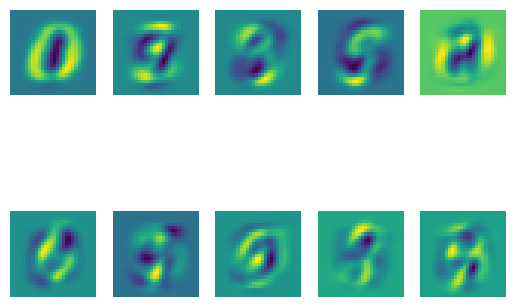

(7000,) (10, 784)
(63000, 784) (7000, 784) (63000,) (7000,)


In [48]:
"""
Below, test your PCA on  MNIST dataset.
Plot and display the selected eigen vectors returned by PCA.
"""

#begin_solution
tx = X_mnist_test[0].reshape((28, 28))
#print(X_mnist_test[:10].T.shape)
t = np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]])
print(X_mnist_test.shape)
mean_vec, top_eig_vecs = pca(X_mnist_test.T, 10)
print(top_eig_vecs.shape)
#print(mean_vec)
plot_eigenvecs(top_eig_vecs, 2, 5)
print(mean_vec.shape, top_eig_vecs.shape)
print(X_mnist.shape, X_mnist_test.shape, Y_mnist.shape, Y_mnist_test.shape)
#end_solution


In [ ]:
#begin_test

#end_test


Now, we can evaluate if the code is working properly by projecting the first image of the test set on the eigen vectors.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>


In [ ]:
def pca_projection(X, mean_vec, eig_vecs):
    """
    Write your implenetation of PCA projection here.

    Arguments:
    X : Data matrix
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector

    Returns:
    weights : Weights corresponding to the eigen vectors
    """

    #begin_solution
    weights = np.dot(X)
    #end_solution


    return weights

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def pca_reconstruction(weights, mean_vec, eig_vecs):
    """
    Write your implementation of PCA reconstruction here.

    Arguments:
    weights : Weights obtained from pca_projection
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector
    """

    #begin_solution

    #end_solution


    return reconstruction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
Below, 
1. Perform  PCA on MNIST training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the 
   pixelwise difference between the two. Use the plotting functions provided.
"""

#begin_solution

#end_solution


**Question 3.b**
<a name='question3b'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_test

#end_test


In [ ]:
def kmeans(X, k, max_iterations=1000):
    """
    Write your implementation of kmeans here.

    Arguments:
    X : Data matrix.
    k : Your choise of k, an integer.
    max_iterations : The number of iterations after which to stop.

    Returns:
    centroids: The learned cluster centroids.
    """

    #begin_solution

    #end_solution


    return centroids

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
Below, test your kmeans on the MNIST dataset.
For all 10 digits, plot and display the cluster centroids as an image grid. 
Use provided plotting functions.
"""

#begin_solution

#end_solution


**Question 3.c**
<a name='question3c'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:

In [ ]:
#begin_test

#end_test


## 4. Linear Classification (18 points)
<a name='question4'></a>

[a)](#question4a) Implement the normal equation-based binary linear classifier lclass(examplesA, examplesB, testExamples) where the first two arguments are the set of samples from class A and class B respectively and the third is the test. The function should return a vector of 0s and 1s, 0 if test is in A and 1 otherwise. It should, for simplicity, both train and test in one function call. (**3 points**)
Test this on all the samples in _IRIS_, Setosa vs non-Setosa, etc and propose a simple analysis (text, figure, table) of the result you find, but not longer than ten sentences. (**4 points** on hidden dataset)

[b)](#question4b) Perform independent research how to do multi-class classification. Implement lclass_prob(examplesA, examplesB, testExamples) and lmclass(examples, class, testExamples) that together perform multi-class classification of the examples examples according to the vector of labels class of the same size and test it with testExamples by returning a matrix, where each row expresses the probability of a sample in testExamples to belong to each class. Give the accuracy of your model. (**5 points** + **6 points** on hidden dataset)
Present findings applying multi-class classification on _IRIS_ dataset with 3 classes. You can include figures and tables if needed. Write no longer than ten sentences.

**Question 4.a**
<a name='question4a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lclass(examplesA, examplesB, testExample):
    """
    Write your implementation of normal equation based linear classifier here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted 0/1 labels on testExample
    """

    #begin_solution

    #end_solution


    return preds

_IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing lclass, test it below on the IRIS dataset.
"""

#begin_solution

#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
Below, plot and display the confusion matrix of your prediction with respect to 
true values. Use provided functions for plotting.
"""

#begin_solution

#end_solution


In [ ]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

**Question 4b**
<a name='question4b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def softmax(preds):
  """
  Write your implementation of the softmax activation here.

  Arguments:
  preds : The output predicted classes from your classifier

  Returns:
  activation : The outputs after applying softmax activation
  """

  #begin_solution

  #end_solution


  return activation

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lclass_prob(examplesA, examplesB, testExample):
    """
    Write your implementation of lclass_prob here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted probabilities of samples in testExample belonging to a class.
    """
    
    #begin_solution

    #end_solution

    
    return preds

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lmclass(examples, labels, testExample):
    """
    Write your implementation of multiclass classifier lmclass here.
    Use your lclass_prob implementation here to solve this.

    Arguments:
    examples : The training data matrix
    labels : The training labels
    testExample : The testing data matrix

    Returns:
    preds_prob : For each sample in testExample, their predicted probabilities
                 of belonging to each class
    """

    #begin_solution

    #end_solution

    
    return preds_prob

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_solution

#end_solution


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

In [ ]:
#begin_test

#end_test


## 5. Non-linear Classification (20 points)
<a name='question5'></a>

[a)](#question5a) Implement classification based on logistic regression using GD by implementing the gradient function dlogistic(preds, X, Y) and optimizing using GD. preds are the prediction from the model, X are the data and Y are the labels. Propose a function interface for your implementation of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[b)](#question5b) Implement classification based on hinge loss using GD by implementing the gradient function dhinge(preds,
W, X, Y) and optimizing using GD. preds are the prediction from the model, W describes the model parameters, X is the data and Y represent the labels. Propose a function interface for your implementation
of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[c)](#question5c) Implement kernel SVM function ksvm(kernel, X, Y, X_test). The function takes as input a kernel function kernel, training data X, Y and a set of test points X_test. The function returns the set of support vectors along with the predicted labels. You are allowed to use scipy optimization library to solve the quadratic problem of SVM. (**5 points** + **7 points** on hidden dataset)

**Question 5.a**
<a name='question5a'></a>

In [ ]:
def gd(X, Y, W,loss_function, loss_gradient, step_size, max_it):
    """
    Implement Gradient Descent here with Logistic loss and its gradient.
    Print the loss values at some interval
    of your choice.

    Arguments:
    X : Data matrix
    Y : Labels
    W : Weights, previously initialized outside this function.
    loss: A callable function that can be used as loss_function(preds,Y) 
              and returns the loss.
    loss_gradient : A callable function that can be used as loss_gradient(preds,X,Y,W=[]) 
              and returns gradient of the loss.
    step_size : Float value of step size to take.
    max_it : Maximum number of iterations, after which to stop

    Returns:
    history : A list containing the loss value at each iteration
    best_w : The best weights corresponding to the best loss value
    """
    
    #begin_solution

    #end_solution

    
    return history, best_w

Implementation of the sigmoid activation function and Logistic Regression.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def sigmoid(z):
    """
    Implement sigmoid activation function here.

    Arguments:
    z : Input scalar or batch of scalars

    Returns:
    activation : Sigmoid activation(s) on z
    """
    
    #begin_solution

    #end_solution


    return activation

def predict(X, W):
    """
    Implement your prediction function here.

    Arguments:
    X : Data matrix
    W : Weight matrix

    Returns:
    prediction : Predicted values using the weights
    """

    #begin_solution

    #end_solution

    
    return prediction

Implementation of the loss function

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def logistic_loss(preds, targets):
    """
    Implement your logistic loss function here.

    Arguments:
    preds : Predicted values
    targets : Target values

    Returns :
    cost : The mean logistic loss value between preds and targets
    """

    #begin_solution

    #end_solution


    return cost

Implementation of the gradient

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def dlogistic(preds, X, Y,W=[]):
    """
    Implement the derivative of the logistic loss here.

    Arguments:
    preds : Predicted values
    X : Input data matrix
    Y : True target values
    W : The weights, optional argument, may/may not be needed depending on the loss function
    """

    #begin_solution

    #end_solution

    
    return J

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing logistic_loss, dlogistic and gd, test it below using the IRIS dataset.
"""

#begin_solution

#end_solution


In [ ]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
Plot and display the progression of your loss values as a graph. Use the 
provided plotting functions.
"""

#begin_solution

#end_solution


In [ ]:
#begin_test

#end_test


**Question 5.b**
<a name='question5b'></a>

Implementation of the Hinge Loss and its gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def hinge_loss(z, Y):
    """
    Write your implementation of hinge loss here.

    Arguments:
    z : Classifier score
    Y : Label

    Returns:
    avg : The average hinge loss
    """

    #begin_solution

    #end_solution


    return avg
  
def dhinge(preds,X, Y, W=[]):
    """
    Implement the derivative of hinge_loss here.

    Arguments:
    preds : The predicted values.
    X : Data matrix
    Y : True Labels
    W : Weights. Optional argument, may/may not be needed, depending on loss function
    Returns:
    J : Gradient of avg hinge_loss with respect to predicted values.
    """

    #begin_solution

    #end_solution

    
    return J

Implementation of the full gradient descent:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing hinge_loss, dhinge and gd, test it below on the IRIS dataset.
"""

#begin_solution

#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
Print the minimum loss
Plot and display the progression of loss. Use provided plotting functions
"""

#begin_solution

#end_solution


In [ ]:
#begin_test

#end_test


**Question 5.c**
<a name='question5c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def ksvm(kernel, X, Y, X_test):
    """
    Write your implementation of Kernel SVM here.

    Arguments:
    kernel : A callable function that takes 2 samples and returns the score
             for them.
    X : Training data matrix
    Y : Training Labels as -1/1
    X_test : Test data matrix

    Returns:
    support_vectors : The learned support vectors
    preds : The predicted labels as -1/1 on the given Test data
    """
    
    #begin_solution

    #end_solution


    return support_vectors, preds

In [ ]:
X_iris_svm = np.copy(X_iris)
Y_iris_svm = np.copy(Y_iris)
Y_iris_svm[Y_iris==0] = -1
Y_iris_svm[Y_iris!=0] = 1

Y_iris_test_svm = np.copy(Y_iris_test)
Y_iris_test_svm[Y_iris_test==0] = -1
Y_iris_test_svm[Y_iris_test!=0] = 1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def kernel(x1, x2):
    """
    Define your kernel function here.

    Arguments:
    x1, x2 : Two data samples (vectors)

    Returns:
    score : The score between x1 and x2
    """

    #begin_solution

    #end_solution


    return score

"""
After implementing ksvm and kernel, test it below on the IRIS dataset.
Print the accuracy of the model.
"""

#begin_solution

#end_solution


In [ ]:
#begin_test

#end_test


## 6. Neural Networks (20 points)
<a name='question6'></a>

[a)](#question6a) Devise a three-layer neural network with n hidden states and sigmoid activations for classification. Explain how many parameters this has in one sentence. (**2 points**)

[b)](#question6b) Implement the binary classifier nnclass(examplesA, examples, testExamples) that is trained with your implementation of (stochastic) GD and your gradient function using the network. (**5 points** + **7 points** on hidden dataset)

[c)](#question6c) Do an analysis how changes affect the accuracy with _MNIST_. Positive labels are assigned to digit 1 and negative samples to other digits. Write no longer than fifteen sentences. A table and / or plot is welcome. (**6 points**)

**Question 6.a**
<a name='question6a'></a>

_Your reply:_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

**Question 6.b**
<a name='question6b'></a>

In [ ]:
def sigmoid(z):
    """
    Write your activation function here.

    Arguments:
    z : Scalar or batch of scalars on which to compute activation(s)

    Returns:
    activation : The activation value(s)
    """

    #begin_solution

    #end_solution


    return activation

def dsigmoid(z):
    """
    Implement the gradient of the activation function.

    Arguments:
    z : Scalar or batch of scalars

    Returns:
    gradient : Gradient(s) of the activation function
    """

    #begin_solution

    #end_solution


    return gradient

In [ ]:
#begin_test

#end_test


Implementation of the forward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def forward_pass(x, W, b):
    """
    Write your implementation of forward pass here.

    Arguments:
    x : Input data matrix
    W : Tuple of weight matrices
    b : Tuple of biases

    Returns:
    y_hat : Output of last layer
    cache : A tuple, that contains all intermediate outputs. These will be
            needed in your backward pass. Save anything in cache that you
            plan to use in the backward pass. It should be a tuple
    """

    #begin_solution

    #end_solution


    return y_hat, cache

#begin_test

#end_test


Implementation of the loss and its associated gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def loss(preds, targets):
    """
    Write your loss function here.

    Arguments:
    preds: The network predictions
    targets: The true labels

    Returns:
    cost: An error metric between pred and targets
    """

    #begin_solution

    #end_solution

    
    return cost

def dloss(preds, target):
    """
    Write the derivative of loss function here.

    Arguments:
    preds : The network predictions
    target : The true labels

    Returns:
    gradient : The derivative of loss function with respect to the
              network outputs
    """

    #begin_solution

    #end_solution


    return gradient

In [ ]:
#begin_test

#end_test


Implementation of the backward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def backward_pass(preds, targets, W, b, X, cache):
    """
    Write your implementation of backward_pass here.

    Arguments:
    preds : The network predictions
    targets : The true labels
    W : A tuple of weight matrices
    b : A tuple of bias values
    X : Input data matrix
    cache : Tuple of Intermediate outputs that you cached in forward_pass

    Returns:
    Gradients with respect to each layer's weights and biases
    """
    
    #begin_solution

    #end_solution

    
    return J_w3, J_w2, J_w1, J_b3, J_b2, J_b1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def training(X, Y, W, b, step_size, max_it):
    """
    Implement your training loop here.

    Arguments:
    X : Input Data matrix
    Y : True labels
    W : A tuple of weight matrices
    step_size : The step size to take for network updates
    max_it : The maximum iterations after which to stop

    Returns:
    W : The trained weights
    b : The trained biases
    history : A list of your loss values at each iteration
    """
    
    #begin_test

    #end_test

    
    #begin_solution

    #end_solution

    
    #begin_test

    #end_test

            
    return W, b, history

In [ ]:
#begin_test

#end_test


In [ ]:
"""
Below, initialize the weights and biases randomly.
Start your training loop with your choice of parameters step_size, max_it
"""

#begin_solution

#end_solution




**Question 6.c**
<a name='question6d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

In [ ]:
#begin_test

#end_test
